In [2]:
from collections import defaultdict

import cv2
import os
import subprocess
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from ultralytics import YOLO

from IPython.display import clear_output

# Adjustment to our task

## Data extraction

In [3]:
def extract_data_from_file(video_name="20231109-112058_10s.mp4", input_path="data/videos", output_path="data/extracted"):
    model = YOLO("yolov8n.pt")

    rows = []
    cap = cv2.VideoCapture(input_path + "/" + video_name)

    for i, (_, boxes, track_ids, _) in enumerate(track(model, cap)):
        for box, track_id in zip(boxes, track_ids):
            x, y, w, h = box
            rows.append([i, track_id, x.item(), y.item()])
    pd.DataFrame(rows, columns=["frame", "track_id", "x", "y"], index=None).to_csv(
        output_path + "/" + video_name.replace(".mp4", ".csv"), index=False
    )

In [4]:
def extract_data(input_path="data/videos", output_path="data/extracted"):

    video_names = os.listdir(input_path)
    not_processed = []

    for video_name in video_names:
        try:
            extract_data_from_file(video_name=video_name, input_path=input_path, output_path=output_path)
        except Exception as e:
            not_processed.append(video_name)

    return not_processed

## Tracking

In [5]:
class DistanceConverter:
    
    @staticmethod
    def pixels2meters(x, y):
        X_px2meters = lambda x, y: (1 - ((1.47*y + 161.76 - x) / (1.47*y + 161.76))) * 8
        Y_px2meters = lambda y: 6.16793058e-07*y**3 -8.61522438e-04*y**2 + 4.31688489e-01*y -4.75010213e+01   
        return X_px2meters(x, y), Y_px2meters(y)
    
    @staticmethod
    def meters2pixels(x, y):
        X_meters2px = lambda x, y: (1.47*y + 161.76) * x/8
        Y_meters2px = lambda y: 1.51690315e-02*y**3 -3.20503299e-01*y**2 + 7.27107405e+00*y+ 1.47945378e+02
        y_px = Y_meters2px(y)
        return X_meters2px(x, y_px), y_px

In [6]:
def calculate_velocity(positions, time, fps):
    dt = np.diff(time) * fps
    velocity = np.linalg.norm(np.diff(positions)) / dt
    # return smooth_data(velocity)
    return velocity


def smooth_data(data, window_size=3):
    return np.concatenate((data[:-1], np.mean(data[-window_size:]) * np.ones(1))) if data[-1] > data[-2]/2 else data

In [7]:
def track(model, cap):
    # Store the track history
    track_history = defaultdict(lambda: [])

    fps = cap.get(cv2.CAP_PROP_FPS)

    # Store the detected frames indices and speeds
    frames_list = defaultdict(lambda: [])
    speeds = defaultdict(lambda: [])

    # Loop through the video frames
    while cap.isOpened():
        # Read a frame from the video
        success, frame = cap.read()

        if success:
            # Run YOLOv8 tracking on the frame, persisting tracks between frames
            results = model.track(frame, persist=True, classes=[0], verbose=False)

            # Get the boxes and track IDs
            boxes = results[0].boxes.xywh.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()

            # Visualize the results on the frame
            annotated_frame = results[0].plot(conf=False)

            # Plot the tracks
            for box, track_id in zip(boxes, track_ids):
                x, y, w, h = box
                track = track_history[track_id]
                track.append((float(x), float(y)))  # x, y center point
                if len(track) > 120:  # retain 90 tracks for 90 frames
                    track.pop(0)

                frames = frames_list[track_id] # indices of frames in which the object was detected
                frames.append(cap.get(cv2.CAP_PROP_POS_FRAMES))
                if len(frames) > 3:
                    frames.pop(0)

                # Calculate the speed
                if len(track) > 2:
                    speed = calculate_velocity(np.array(track)[-3:], np.array(frames), fps)[-1]
                    speeds[track_id] = speed

                    # Draw the speed in box title
                    # cv2.putText(annotated_frame, f"{speed:.2f} px/s", (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    #             (255, 255, 255), 1)                    
                
                x_meters, y_meters = DistanceConverter.pixels2meters(x, y)
                cv2.putText(annotated_frame, f"x={x_meters:.2f}m, y={y_meters:.2f}m", (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                                (255, 255, 255), 1)

                # Draw the tracking lines
                points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(annotated_frame, [points], isClosed=False, color=(230, 230, 230), thickness=10)

                area = np.array([[[0, 151], [383, 151], [978, 555], [0, 555]]])
                alpha = 0.1
                overlay = annotated_frame.copy()
  
                cv2.polylines(overlay, pts = area, isClosed = True, color=(255, 0, 0),thickness=2)
                cv2.fillPoly(overlay, area, (255,0,0))
                annotated_frame = cv2.addWeighted(overlay, alpha,annotated_frame , 1 - alpha, 0)


            yield (annotated_frame, boxes, track_ids, speeds)

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break
        else:
            # Break the loop if the end of the video is reached
            break

    # Release the video capture object and close the display window
    cap.release()
    cv2.destroyAllWindows()

## Tracking visualisation

In [18]:
plan = plt.imread("data/bg.png")

def plot_people_on_plan(people, i):
    clear_output(wait=True)
    plt.figure(figsize=(7, 7))
    plt.imshow(plan, extent=[0, 8, 0, 32])
    plt.title(f"Second {i // 20}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(np.arange(0, 8, 1))
    plt.yticks(np.arange(0, 32, 2))
    plt.xlim(0, 8)
    plt.ylim(32, 0)
    for track_id, (x, y) in people.items():
        plt.scatter(x, y, label=f"Person {track_id}")
    plt.legend(loc="center left", bbox_to_anchor=(1, 1))
    plt.grid()
    plt.show()


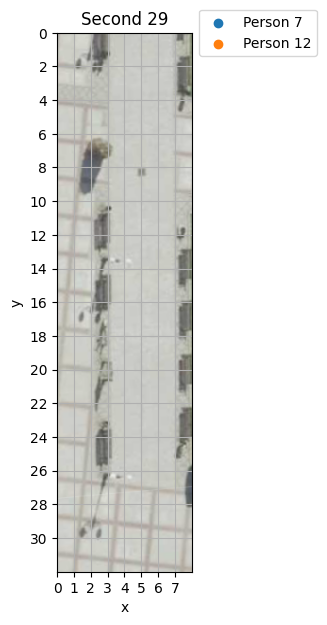

In [19]:
model = YOLO("yolov8n.pt")

video_path = 'data/videos/20231109-113145_30s.mp4'
cap = cv2.VideoCapture(video_path)

height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = cap.get(cv2.CAP_PROP_FPS)
VIDEO_CODEC = "MP4V"

output_video_name = "result.mp4"
tmp_output_path = "tmp_" + output_video_name

check_conversion = False
verbose = False
plotting = True

output_video = cv2.VideoWriter(
    tmp_output_path, cv2.VideoWriter_fourcc(*VIDEO_CODEC), fps, (width, height)
)

people_at_frame = defaultdict(lambda: defaultdict(lambda: [0, 0]))

for i, (frame, boxes, track_ids, speeds) in enumerate(track(model, cap)):
    clear_output(wait=True)
    cv2.imshow("YOLOv8 Tracking", frame)

    for box, track_id in zip(boxes, track_ids):
        x, y, w, h = box
        x, y = int(x), int(y)
        
        if check_conversion:
            x_prime, y_prime = DistanceConverter.meters2pixels(*DistanceConverter.pixels2meters(x, y))
            area = np.array([[[0, 151], [383, 151], [978, 555], [0, 555]]])
            point = np.array([[[x, y]]])
            if cv2.pointPolygonTest(area, (x, y), False) > 0:
                assert abs(x_prime - x) < x / 20 and abs(y_prime - y) < y / 20, f"Error in conversion: {x, y} -> {x_prime, y_prime}"

        if verbose:
            print(
                f"Person {track_id} is at ({x}, {y}) "
                + (
                    f"commuting at {speeds[track_id]:.2f} px/s"
                    if track_id in speeds
                    else ""
                )
            )

        people_at_frame[i][track_id] = DistanceConverter.pixels2meters(x, y)

    if plotting and i % 10 == 0:
        plot_people_on_plan(people_at_frame[i], i)
    output_video.write(frame)

output_video.release()

if os.path.exists(output_video_name):
    os.remove(output_video_name)

subprocess.run(
    [
        "ffmpeg",
        "-i",
        tmp_output_path,
        "-crf",
        "18",
        "-preset",
        "veryfast",
        "-hide_banner",
        "-loglevel",
        "error",
        "-vcodec",
        "libx264",
        output_video_name,
    ]
)
os.remove(tmp_output_path)